imports

In [67]:
import ast
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from tg.grammar_ru.common import Loc
from tg.grammar_ru.corpus import CorpusReader, CorpusBuilder, BucketCorpusBalancer
from tg.grammar_ru.corpus.corpus_reader import read_data
import os
from pathlib import Path
from dotenv import load_dotenv
from tg.grammar_ru.components.yandex_storage.s3_yandex_helpers import S3YandexHandler
from tg.grammar_ru.components.yandex_delivery.training_logs import S3TrainingLogsLoader, TrainingLogsViewer

from yo_fluq_ds import Queryable, Query, fluq
import plotly.express as px
from tg.grammar_ru.common import Separator

from typing import List, Union
import numpy as np
import torch
import math
import pandas as pd
from sklearn.metrics import confusion_matrix

pd.set_option('display.max_rows', 500)
load_dotenv(Loc.root_path / 'environment.env')


def get_tasks(bucket, tasks_list_s3_path):
    tmp_local_file = Loc.temp_path / tasks_list_s3_path.split('/')[-1]
    S3YandexHandler.download_file(bucket, tasks_list_s3_path, tmp_local_file)
    with open(tmp_local_file, 'r') as f:
        tasks = ast.literal_eval(f.read())
    return tasks


def plot_metrics(metrics, title=""):
    plt.plot(TrainingLogsViewer.get_metric_by_job(
        metrics, 'accuracy_display'), label='accuracy_display')
    plt.plot(TrainingLogsViewer.get_metric_by_job(
        metrics, 'accuracy_test'), label='accuracy_test')
    plt.title(title)
    plt.legend()
    plt.show()


def plot_cm(cm):
    fig = go.Figure(data=go.Heatmap(z=cm,
                                    text=cm,
                                    x=cm.columns,
                                    y=cm.index,
                                    texttemplate="%{text}",
                                    colorscale='Blues'))
    fig.show()

def get_label(s):
    return int(s.split('_label_')[1])

def get_true_and_pred(result_df):
    pred_col_names = [c for c in result_df.columns if 'predicted_label' in c ]
    true_col_names = [c for c in result_df.columns if 'true_label' in c ]
    y_pred = result_df[pred_col_names].idxmax(axis="columns").apply(get_label)
    true_probs = result_df[true_col_names]
    y_true = true_probs.idxmax(axis="columns").apply(get_label)

    result_df['pred_label'] = y_pred
    result_df['true_label'] = y_true
    result_df['pred_score'] = result_df[pred_col_names].max(axis=1)

    return y_true, y_pred

def get_worst_words_sents(result_df, src, true_label: int, pred_label: int, worst_words_cnt: int):
    one_inst_another = result_df[(result_df.true_label == true_label) & (
        result_df.pred_label == pred_label)]
    thrsh = one_inst_another[f'predicted_label_{pred_label}'].sort_values(
        ascending=False).head(worst_words_cnt).min()
    worst_mistakes_scores = one_inst_another[
        one_inst_another[f'predicted_label_{pred_label}'] >= thrsh]

    worst_words = (src[src.word_id.isin(worst_mistakes_scores.word_id)]
                   [['word_id', 'sentence_id', 'word']])[:worst_words_cnt]
    worst_sents = worst_words['sentence_id'].unique()
    worst_sents_df = src[src.sentence_id.isin(worst_sents)]
    # worst_sents_df.loc[worst_sents_df.index, 'pred_score'] = -1
    # worst_sents_df.loc[worst_sents_df[worst_sents_df.word_id.isin(worst_mistakes_scores.word_id)].index, "pred_score"] = one_inst_another.pred_score.values
    return worst_words, worst_sents_df

def get_best_words_sents(result_df, src, pred_label: int, words_cnt: int):
    """ 
    Находит слова, в которых сеть была уверена в ответе и ответ верный
    """
    correct_df = result_df[result_df.true_label==pred_label]
    thrsh = correct_df[f'predicted_label_{pred_label}'].sort_values(
        ascending=False).head(words_cnt).min()
    best_scores = correct_df[correct_df[f'predicted_label_{pred_label}']>=thrsh]
    best_words = (src[src.word_id.isin(best_scores.word_id)])[['word_id', 'sentence_id', 'word']][:words_cnt]
    best_sents = best_words.sentence_id.unique()
    best_sents_df = src[src.sentence_id.isin(best_sents)]
    return best_words, best_sents_df


In [2]:
project_name = 'agreementproject'
dataset_name = 'agreement_adj_mid50_0_declination'
bucket = 'agreementadjbucket'

Измененный бандл:
* Удалили slovnet
* Удалили ОЮ

### Filter bundle

In [3]:
new = {'ая', 'ого', 'ое', 'ой', 'ом', 'ому',
       'ую', 'ые', 'ый', 'ым', 'ыми', 'ых'} # тут нет окнчаний превосходных форм и ою

# полнейшей, наипрочнейшего, важнейшие,меньшим, милейший, наистраннейшее, новейших, малейшем, слабейшему, меньшими
good = {'ая', 'его', 'ее', 'ей', 'ем', 'ему',
        'ие', 'ий', 'им', 'ими', 'их', 'ую', 'яя', 'юю'}

big = {'ая', 'ие', 'им', 'ими', 'их', 'ого',
       'ое', 'ой', 'ом', 'ому', 'ою', 'ую'}

POSSIBLE_ENDINGS = set().union(new, good, big)
endings_nums = {e: i for i, e in enumerate(
    sorted(list(POSSIBLE_ENDINGS)))}
num_by_ending = endings_nums
ending_by_num = {v:k for k, v in endings_nums.items()}

new_declination_labels = {num for e, num in endings_nums.items() if e in new}


В датасете только слова 1-го типа склонения. Новый. Возможно 12 окончаний. 

In [4]:
new_num_by_ending = {e:num for e,num in num_by_ending.items() if e in new}
new_num_by_ending

{'ая': 0,
 'ого': 11,
 'ое': 12,
 'ой': 13,
 'ом': 14,
 'ому': 15,
 'ую': 17,
 'ые': 18,
 'ый': 19,
 'ым': 20,
 'ыми': 21,
 'ых': 22}

Оставили только слова типа "Новый"

In [5]:
from tg.common import DataBundle
from tg.common.ml.batched_training import IndexedDataBundle
from tg.grammar_ru.components.plain_context_builder import PlainContextBuilder
bundle_0_declination_path = Loc.data_cache_path/'bundles/agreement/mid50_0_declination'
# bundle_full_0_declination_path = Loc.data_cache_path/'bundles/agreement/full_mystemless_0_declination'


In [14]:
# db = DataBundle.load(Loc.data_cache_path/'bundles/agreement/mid50')
# ids_0_type=set(db.src[db.src.declension_type==0].word_id)
# db['index'] = db.index[db.index.word_id.isin(ids_0_type) & db.index.label.isin(new_declination_labels)]
# db = db.copy()
# db.save(bundle_0_declination_path)

In [70]:
db = DataBundle.load(Loc.data_cache_path/'bundles/agreement/mid50')
ids_0_type=set(db.src[db.src.declension_type==0].word_id)
db['index'] = db.index[db.index.word_id.isin(ids_0_type) & db.index.label.isin(new_declination_labels)]
db = db.copy()
db.save(bundle_0_declination_path)

Проверим отфильтрованный бандл

In [16]:
del db
db = DataBundle.load(bundle_0_declination_path)


In [17]:
db

{'index': {'shape': (88060, 4), 'index_name': 'sample_id'}, 'pymorphy': {'shape': (2499338, 16), 'index_name': 'word_id'}, 'src': {'shape': (2499338, 18), 'index_name': None}}

In [18]:
db.src[db.src.word_id.isin(db.index.word_id)].declension_type.unique()

array([0])

In [19]:
# Все возможные окончания слов 0-го типа склонения. "Новый"
db.index.label.replace(ending_by_num).unique()

array(['ые', 'ого', 'ый', 'ых', 'ой', 'ая', 'ое', 'ом', 'ую', 'ому', 'ым',
       'ыми'], dtype=object)

Отправка бандла

In [71]:
project_name = 'agreementproject'
# dataset_name = 'agreement_adj_mid50_0_declination'#tiny_0_declination
dataset_name = 'agreement_adj_toy'

bucket = 'agreementadjbucket'

In [72]:
from tg.grammar_ru.components.yandex_storage.s3_yandex_helpers import S3YandexHandler
# try:
#     S3YandexHandler.create_bucket(bucket)
# except:
#     pass 

In [73]:
s3path = f'datasphere/{project_name}/datasets/{dataset_name}'
S3YandexHandler.upload_folder(bucket, s3path, bundle_0_declination_path)

# Обучение

Добавим в сеть кросс-энтропию.

cross-entropy & softmax 40ep

output/
output/batcher.pkl
output/history.pkl
output/info.pkl
output/metrics.pkl
output/model.pkl
output/result_df.parquet
output/test_splits.pkl
output/train_split.pkl
output/training_task.pkl


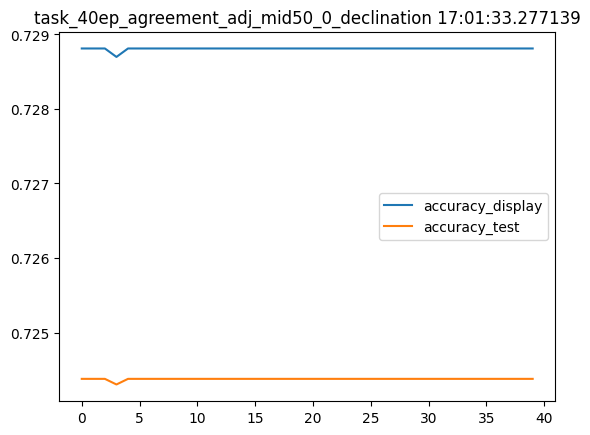

In [13]:
tasks = get_tasks(bucket, 'datasphere/agreementproject/job_info/job_agreementproject_17:01:33.277101.txt')

loader = S3TrainingLogsLoader(bucket, project_name)
metrics = loader.load_metrics(tasks)

unzipped_folder = (Loc.root_path /
                   'temp'/'training_results' /
                   f'{tasks[0]}.unzipped')
result_df = pd.read_parquet(unzipped_folder/'output'/'result_df.parquet')
y_true, y_pred = get_true_and_pred(result_df)

plot_metrics(metrics, tasks[0])
sorted_nums = sorted(list(y_true.unique()))
cm = pd.DataFrame(
    confusion_matrix(y_true, y_pred,
                     #    normalize='true'
                     ).round(2),
    columns=[f'pred {n,ending_by_num[n]}' for n in sorted_nums],
    index=[f'actual {n,ending_by_num[n]}' for n in sorted_nums]
)
plot_cm(cm)


In [45]:
pred_col_names = [c for c in result_df.columns if 'predicted_label' in c ]
true_col_names = [c for c in result_df.columns if 'true_label' in c ]

In [17]:
# metrics[metrics.metric=='accuracy_display']

### SoftmaxLess

В документации сказано, что CrossEntropyLoss ожидает из сети ненормированные числа. Поэтому удалили softmax

output/
output/batcher.pkl
output/history.pkl
output/info.pkl
output/metrics.pkl
output/model.pkl
output/result_df.parquet
output/test_splits.pkl
output/train_split.pkl
output/training_task.pkl


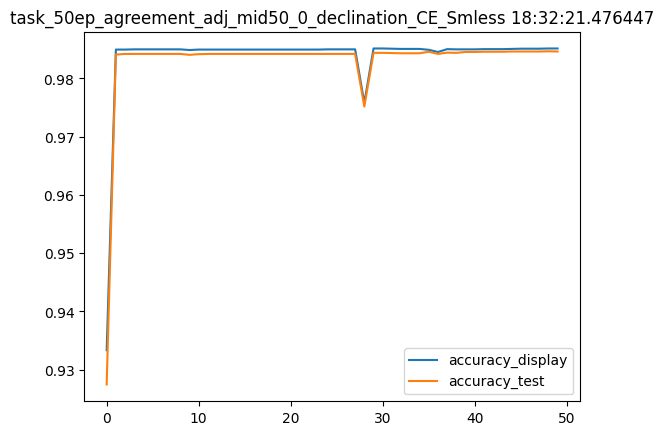

In [15]:
tasks = get_tasks(bucket,
 'datasphere/agreementproject/job_info/job_agreementproject_18:32:21.476408.txt')

loader = S3TrainingLogsLoader(bucket, project_name)
metrics = loader.load_metrics(tasks)

unzipped_folder = (Loc.root_path /
                   'temp'/'training_results' /
                   f'{tasks[0]}.unzipped')
result_df = pd.read_parquet(unzipped_folder/'output'/'result_df.parquet')
y_true, y_pred = get_true_and_pred(result_df)

plot_metrics(metrics, tasks[0])
sorted_nums = sorted(list(y_true.unique()))
cm = pd.DataFrame(
    confusion_matrix(y_true, y_pred,
                        # normalize='true'
                     ).round(2),
    columns=[f'pred {ending_by_num[n]}' for n in sorted_nums],
    index=[f'actual {ending_by_num[n]}' for n in sorted_nums]
)
plot_cm(cm)
cm = pd.DataFrame(
    confusion_matrix(y_true, y_pred,
                        normalize='true'
                     ).round(2),
    columns=[f'pred {ending_by_num[n]}({n})' for n in sorted_nums],
    index=[f'actual {ending_by_num[n]}({n})' for n in sorted_nums]
)
plot_cm(cm)

#### Выводы

Отлично обучилась, за исключением одного класса - ОМУ

In [18]:
db = DataBundle.load(Loc.data_cache_path/'bundles/agreement/mid50')


In [20]:
from tg.grammar_ru.common import Separator

true_label = 15
pred_label = 20
worst_words, worst_sents_df = get_worst_words_sents(
    result_df, db.src, true_label=true_label, pred_label=pred_label, worst_words_cnt=4)
print(f"Predicted  {ending_by_num[pred_label]}  instead of  {ending_by_num[true_label]} " )
Separator.Viewer().tooltip("word_id").color('word_id',
                                            value_to_color={
                                                wid: 'red' for wid in worst_words.word_id}
                                            ).to_html_display(worst_sents_df)


Predicted  ым  instead of  ому 


In [25]:
result_df.pred_score.round(6).value_counts()

1.000000    52178
0.000000      816
0.999999        4
0.999988        2
0.999980        1
0.999969        1
0.999996        1
0.999978        1
0.999989        1
Name: pred_score, dtype: int64

In [32]:
pred_col_names = [c for c in result_df.columns if 'predicted_label' in c ]
true_col_names = [c for c in result_df.columns if 'true_label' in c ]
# result_df[pred_col_names].round(2)[:20]

In [31]:
result_df[result_df.pred_score<0.001][pred_col_names]

,predicted_label_19,predicted_label_18,predicted_label_13,predicted_label_22,predicted_label_20,predicted_label_11,predicted_label_0,predicted_label_12,predicted_label_17,predicted_label_21,predicted_label_14,predicted_label_15
sample_id,,,,,,,,,,,,
195,3.576408e-26,0.0,9.117971e-22,0.0,1.555851e-11,0.000000e+00,1.803381e-18,1.505761e-36,0.000000e+00,0.0,1.215288e-21,1.694844e-13
216,3.256505e-26,0.0,2.778800e-21,0.0,1.546899e-12,6.687379e-39,1.568575e-17,6.624346e-36,0.000000e+00,0.0,9.512640e-21,1.467655e-13
382,3.590529e-26,0.0,9.113799e-22,0.0,1.550787e-11,0.000000e+00,1.810805e-18,1.503076e-36,0.000000e+00,0.0,1.216476e-21,1.694941e-13
616,3.573176e-26,0.0,9.126322e-22,0.0,1.555934e-11,0.000000e+00,1.801380e-18,1.507164e-36,0.000000e+00,0.0,1.215358e-21,1.694915e-13
2029,3.127715e-26,0.0,2.906941e-21,0.0,1.536536e-12,7.054502e-39,1.510764e-17,6.944003e-36,0.000000e+00,0.0,9.621725e-21,1.469210e-13
...,...,...,...,...,...,...,...,...,...,...,...,...
157006,3.242634e-26,0.0,2.789984e-21,0.0,1.552293e-12,6.697028e-39,1.564297e-17,6.640741e-36,0.000000e+00,0.0,9.498245e-21,1.467907e-13
157103,3.558702e-26,0.0,9.163580e-22,0.0,1.556070e-11,0.000000e+00,1.792127e-18,1.513640e-36,0.000000e+00,0.0,1.215789e-21,1.695219e-13
157578,4.001912e-37,0.0,1.380932e-10,0.0,2.095918e-12,1.029666e-25,3.611468e-31,2.105498e-24,1.024909e-24,0.0,7.446962e-20,4.406509e-13


In [ ]:
#TODO context_size =7 
# todo weight of class in CE


In [35]:
from sklearn.metrics import classification_report

print(classification_report(result_df.true_label, result_df.pred_label))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4155
          11       1.00      1.00      1.00      4382
          12       1.00      1.00      1.00      3772
          13       0.98      1.00      0.99      6282
          14       1.00      1.00      1.00      2085
          15       1.00      0.02      0.04       816
          17       1.00      1.00      1.00      3095
          18       1.00      1.00      1.00      6787
          19       1.00      1.00      1.00      8879
          20       0.88      1.00      0.93      4933
          21       1.00      1.00      1.00      2524
          22       1.00      1.00      1.00      5295

    accuracy                           0.98     53005
   macro avg       0.99      0.92      0.91     53005
weighted avg       0.99      0.98      0.98     53005



### Добавим веса классов в кросс-энтропию

In [68]:
def get_class_weights(db):
    """ Normalize weights. Sum will be equal to number of classes"""
    weights = db.index.label.value_counts().sort_index()
    lw = torch.tensor(list(weights)).float()
    return (lw / lw.sum()) * len(lw)




In [6]:
bundle_0_declination_path = Loc.data_cache_path/'bundles/agreement/mid50_0_declination'
db = DataBundle.load(bundle_0_declination_path)


In [69]:
get_class_weights(db)

tensor([0.9378, 0.9911, 0.8501, 1.4397, 0.4611, 0.1819, 0.7157, 1.5266, 2.0020,
        1.1174, 0.5740, 1.2026])

output/
output/batcher.pkl
output/history.pkl
output/info.pkl
output/metrics.pkl
output/model.pkl
output/result_df.parquet
output/test_splits.pkl
output/train_split.pkl
output/training_task.pkl


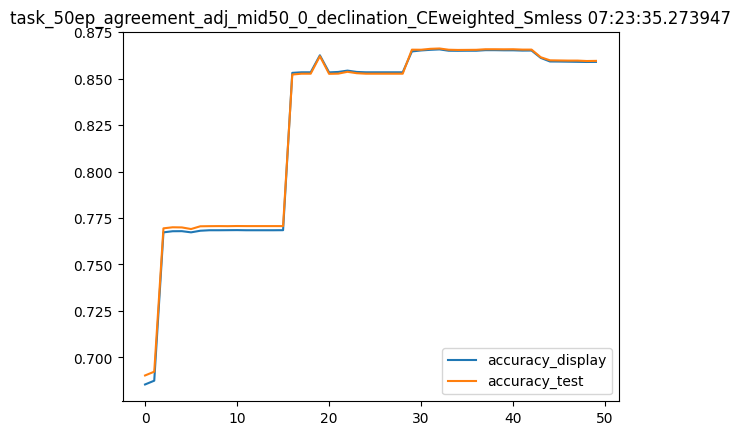

In [79]:
tasks = get_tasks(bucket,
 'datasphere/agreementproject/job_info/job_agreementproject_07:23:35.273901.txt')

loader = S3TrainingLogsLoader(bucket, project_name)
metrics = loader.load_metrics(tasks)

unzipped_folder = (Loc.root_path /
                   'temp'/'training_results' /
                   f'{tasks[0]}.unzipped')
result_df = pd.read_parquet(unzipped_folder/'output'/'result_df.parquet')
y_true, y_pred = get_true_and_pred(result_df)

plot_metrics(metrics, tasks[0])
sorted_nums = sorted(list(y_true.unique()))
cm = pd.DataFrame(
    confusion_matrix(y_true, y_pred,
                        # normalize='true'
                     ).round(2),
    columns=[f'pred {ending_by_num[n]}' for n in sorted_nums],
    index=[f'actual {ending_by_num[n]}' for n in sorted_nums]
)
plot_cm(cm)
cm = pd.DataFrame(
    confusion_matrix(y_true, y_pred,
                        normalize='true'
                     ).round(2),
    columns=[f'pred {ending_by_num[n]}({n})' for n in sorted_nums],
    index=[f'actual {ending_by_num[n]}({n})' for n in sorted_nums]
)
plot_cm(cm)

##### Выводы

Стало хуже.
Возможно потому, что распределение в батче (и тем более в мини-батче) отличается от распределения во всем датасете